In [1]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in ".\animefacedataset" (use force=True to force download)


In [2]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [4]:
image_size = 64
batch_size = 300
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

In [9]:
# show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [13]:
import torch.nn as nn

In [14]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [15]:
discriminator = to_device(discriminator, device)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [16]:
latent_size = 128

In [17]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

> "The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://stackoverflow.com/questions/41489907/generative-adversarial-networks-tanh)


Note that since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the similar transformation to the images in the training dataset. Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

torch.Size([300, 128, 1, 1])
torch.Size([300, 3, 64, 64])


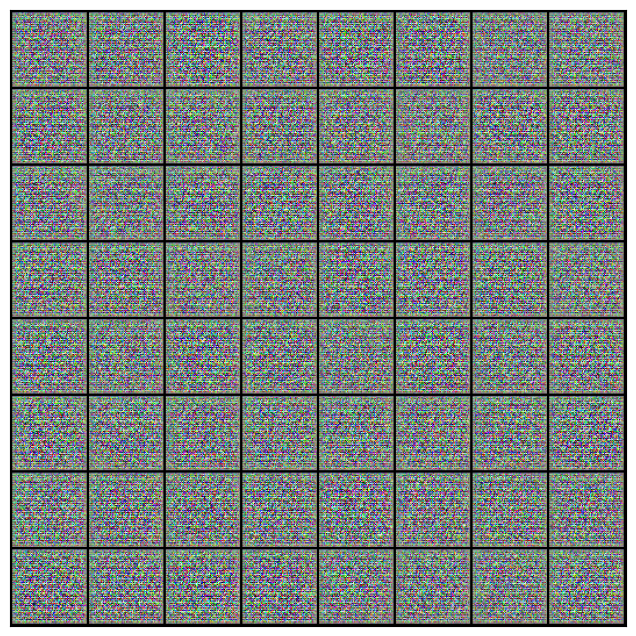

In [18]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
print(xb.shape)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [19]:
generator = to_device(generator, device)

In [20]:
import torch.nn.functional as F

In [21]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [22]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [23]:
from torchvision.utils import save_image

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


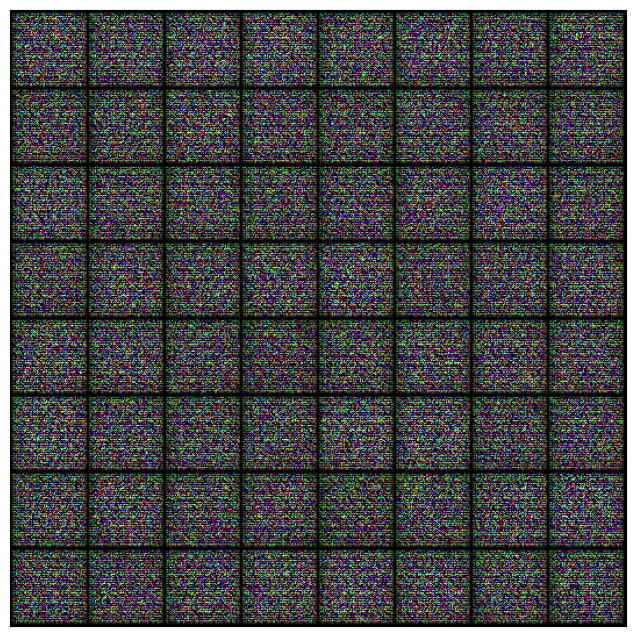

In [27]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [28]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [29]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [30]:
lr = 0.0002
epochs = 25

In [31]:
import time

In [32]:
%%time
history = fit(epochs, lr)

  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 1.9821, loss_d: 0.5802, real_score: 0.7304, fake_score: 0.1559
Saving generated-images-0001.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 3.0394, loss_d: 0.5961, real_score: 0.6745, fake_score: 0.1148
Saving generated-images-0002.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.5951, loss_d: 1.3404, real_score: 0.9366, fake_score: 0.6863
Saving generated-images-0003.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 3.9042, loss_d: 0.4212, real_score: 0.8023, fake_score: 0.1427
Saving generated-images-0004.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 5.0395, loss_d: 0.5842, real_score: 0.8016, fake_score: 0.2691
Saving generated-images-0005.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 8.0489, loss_d: 0.8208, real_score: 0.8977, fake_score: 0.4729
Saving generated-images-0006.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 3.3959, loss_d: 0.2306, real_score: 0.8762, fake_score: 0.0789
Saving generated-images-0007.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 3.6014, loss_d: 0.3779, real_score: 0.7529, fake_score: 0.0449
Saving generated-images-0008.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.2043, loss_d: 0.0889, real_score: 0.9886, fake_score: 0.0703
Saving generated-images-0009.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 7.0264, loss_d: 0.0637, real_score: 0.9531, fake_score: 0.0113
Saving generated-images-0010.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 4.8213, loss_d: 0.1488, real_score: 0.9160, fake_score: 0.0493
Saving generated-images-0011.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 6.0115, loss_d: 0.3068, real_score: 0.9568, fake_score: 0.2045
Saving generated-images-0012.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 6.0061, loss_d: 0.2110, real_score: 0.9514, fake_score: 0.1359
Saving generated-images-0013.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 3.6155, loss_d: 0.1558, real_score: 0.9243, fake_score: 0.0595
Saving generated-images-0014.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 4.8202, loss_d: 0.2745, real_score: 0.8887, fake_score: 0.1272
Saving generated-images-0015.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.2506, loss_d: 0.0798, real_score: 0.9666, fake_score: 0.0416
Saving generated-images-0016.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 4.8589, loss_d: 0.1734, real_score: 0.9097, fake_score: 0.0613
Saving generated-images-0017.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 5.5149, loss_d: 0.1595, real_score: 0.9503, fake_score: 0.0944
Saving generated-images-0018.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 4.8887, loss_d: 0.2407, real_score: 0.9292, fake_score: 0.1359
Saving generated-images-0019.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 6.0969, loss_d: 0.1975, real_score: 0.9547, fake_score: 0.1256
Saving generated-images-0020.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 5.4617, loss_d: 0.1488, real_score: 0.9744, fake_score: 0.1062
Saving generated-images-0021.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 4.8257, loss_d: 0.2015, real_score: 0.9545, fake_score: 0.1323
Saving generated-images-0022.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 3.6764, loss_d: 0.1612, real_score: 0.8987, fake_score: 0.0423
Saving generated-images-0023.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 9.1983, loss_d: 0.4886, real_score: 0.9984, fake_score: 0.3407
Saving generated-images-0024.png


  0%|          | 0/212 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 3.4542, loss_d: 0.2483, real_score: 0.8674, fake_score: 0.0714
Saving generated-images-0025.png
CPU times: total: 11min
Wall time: 34min 23s
